In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# To allow the importation of plotting function module anywhere
import sys
import platform
if platform.system() == 'Linux':
    sys.path.insert(0,'/nethome/palmerio/Dropbox/Plotting_GUI/Src')
elif platform.system() == 'Darwin': 
    sys.path.insert(0,'/Users/palmerio/Dropbox/Plotting_GUI/Src')
import plotting_functions as pf

import corner
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from pathlib import Path
plt.style.use('presentation')
mpl.rcParams.update({"figure.autolayout": False})

In [2]:
def calculate_Cvar(fname, pflx_key='pflx_band_phtflux',
                          flnc_key='flnc_band_phtflnc',
                          t90_key='t90',
                          lac=False,
                          pflx_min=None,
                          verbose=False, add_fluences=False):
    """
        Read the fname provided with pandas and extract T90, fluence and peak flux.
        The mean flux is then calculated as fluence/T90.
        Cvar is then calculated as mean flux/peakflux.
        lac means long and complete; if True the sample will be cut at the desired minimum pflx
    """
    # Read the entire file
    df_obs = pd.read_csv(fname, sep='|', header=2, low_memory=False)
    # Strip the colum names to remove whitespaces
    df_obs.rename(columns=lambda x:x.strip(), inplace=True)
    # Activate verbose to check the column names
    if verbose:
        for i,col in enumerate(df_obs.columns):
            print(i,col)
    if add_fluences:
        flnc_2 = 'fluence_2'
        flnc_3 = 'fluence_3'
        flnc_key = 'flnc_tot'
        df_obs[flnc_2] = pd.to_numeric(df_obs[flnc_2], errors='coerce')
        df_obs[flnc_3] = pd.to_numeric(df_obs[flnc_3], errors='coerce')
        df_obs[flnc_key] = df_obs[flnc_2] + df_obs[flnc_3]

    # Only keep necessary data in new sub-dataframe
    necessary_data = {'pflx':df_obs[pflx_key], 'flnc':df_obs[flnc_key], 't90':df_obs[t90_key]}
    df_sub = pd.DataFrame(data=necessary_data)
    
    # Convert the values read from strings to numbers
    if verbose:
        print("Before conversion to numeric:\n", df_sub)
    for key in ['pflx', 'flnc', 't90']:
        df_sub[key] = pd.to_numeric(df_sub[key], errors='coerce')
    
    # Remove NaN values
    if verbose:
        print("Before removing NaNs:\n", df_sub)
    df_sub = df_sub.dropna(axis=0)

    # Calculate mean flux and Cvar
    df_sub['mflx'] = df_sub['flnc'] / df_sub['t90']
    df_sub['Cvar'] = df_sub['mflx'] / df_sub['pflx']
    # Only keep the long and complete part of the sample
    if lac:
        df_sub = df_sub[(df_sub['t90'] > 2) & (df_sub['pflx'] > pflx_min)]
    return df_sub

In [3]:
def cut_Cvar_sample(df, mask, show_plot=False, title=None):
    """
        Apply some mask on the Cvar data frame and examine in detail the Cvar vs T90 plane.
    """
    subdf = df[mask].copy()
    if show_plot:
        fig, axes = pf.cool_hist2d(np.log10(subdf['t90']),
                                   np.log10(subdf['Cvar']),
                                   c=np.log10(subdf['pflx']),
                                   xlabel=r'$\rm \log(T_{90}~[s])$',
                                   ylabel=r'$\rm \log(C_{var})$',
                                   left_kdeplot_kwargs={'color':'k', 'label':None, 'legend':False},
                                   top_kdeplot_kwargs={'color':'k', 'label':None, 'legend':False},
                                   left_hist_kwargs={'color':'lightgray','alpha':0.9,'bins':20, 'edgecolor':'k', 'label':None},
                                   top_hist_kwargs={'color':'lightgray','alpha':0.9,'bins':20, 'edgecolor':'k', 'label':None},
                                   cmap='Greys', cblabel=r'$\log(N~[\rm ph\,s^{-1}\,cm^{-2}])$')

        corner.hist2d(np.asarray(np.log10(subdf['t90'])), np.asarray(np.log10(subdf['Cvar'])),
                                 plot_datapoints=False,
                                 plot_density=False,
                                 ax = axes['center'],
                                 no_fill_contours=True,
                                 color='k',
                                 contour_kwargs={'linewidths':2})

        if title is not None:
            axes['center'].text(0.3, 0.9, title, transform=axes['center'].transAxes, **{'size':18})
    return subdf

In [4]:
def fit_Cvar_T90_slope(df, precision=1000, show_plot=False):
    """
        Fit the slope of the Cvar vs T90 relation by minimizing the scatter of the decorrelated Cvar sample
    """
    

    from scipy.stats import linregress
    best_slope, best_intercept, r_value, p_value, std_err = linregress(np.log10(df['t90']),
                                                                  np.log10(df['Cvar']))
    
    mu, std = norm.fit(np.log10(df['Cvar'])-best_slope*np.log10(df['t90'])-best_intercept)
    mu_t90, std_t90 = norm.fit(np.log10(df['t90']))

    fig, axes = pf.cool_hist2d(np.log10(df['t90']),
                np.log10(df['Cvar'])-best_slope*np.log10(df['t90'])-best_intercept,
                c=np.log10(df['pflx']),
                xlabel=r'$\rm \log(T_{90}~[s])$',
                ylabel=r'$\rm \log(C_{var})$'+f'-{np.abs(best_slope):.3f}'+r'$\,\rm \log(T_{90}~[s])$'+f'+{best_intercept:.3f}',
                cblabel=r'$\log(N~[\rm ph\,s^{-1}\,cm^{-2}])$',
                top_hist_kwargs={'label': None,
                                 'bins': 20,
                                 'color': 'lightgrey',
                                 'edgecolor':'k'},
                left_hist_kwargs={'label': None,
                                 'bins': 20,
                                 'color': 'lightgrey',
                                 'edgecolor':'k'},)

    x = np.linspace(-1,1,1000)
    x_t90 = np.linspace(0.3,3,1000)
    axes['left'].plot(pf.gaussian(x,mu,std,normed=True),x, label=r'$\mu = ${:.2f}~$\sigma =${:.2f}'.format(mu, std))
    axes['top'].plot(x_t90,pf.gaussian(x_t90,mu_t90,std_t90,normed=True), label=r'$\mu = ${:.2f}~$\sigma =${:.2f}'.format(mu_t90, std_t90))

    axes['left'].legend()
    axes['top'].legend()
    fit_results = {'best_slope':best_slope,
                   'best_intercept':best_intercept,
                   'mu_decorr':mu,
                   'sigma_decorr':std,
                   'mu_t90':mu_t90,
                   'sigma_t90':std_t90}
    return fit_results

In [5]:
def summary_of_Cvar(fname,
                    sample_name,
                    pflx_key='pflx_band_phtflux',
                    flnc_key='flnc_band_phtflnc',
                    t90_key='t90',
                    lac=False,
                    pflx_min=None,
                    add_fluences=False,
                    fig_title='Long and complete GBM sample\nin the BATSE band (50-300 keV)'):
    """
        Convenience function to rapidly execute each step in the Cvar chain and output the relevant information only.
    """
    # Compute Cvar
    df = calculate_Cvar(fname,pflx_key=pflx_key,
                          flnc_key=flnc_key,
                          t90_key=t90_key,
                          lac=lac,
                          pflx_min=pflx_min, add_fluences=add_fluences)
    fig_corner = corner.corner(np.log10(df), labels=['log Peak flux',
                                          'log Fluence',
                                          'log T90',
                                          'log Mean flux',
                                          'log Cvar'])
    fig_corner.suptitle(fig_title, **{'size':20})
    # Cut out bad part of sample
    T90_condition = (df['t90'] >= 2)
    Pflx_condition = (df['pflx'] >= pflx_min)
    outliers_condition = (df['t90'] <= 10**0.6) & (df['Cvar'] <= 10**-0.5)
    final_mask = T90_condition & Pflx_condition & ~outliers_condition
    
    df_lac = cut_Cvar_sample(df, final_mask, title=fig_title)
    
    # Fit the Cvar vs T90 plane
    fit_results = fit_Cvar_T90_slope(df_lac)
    
    fig, axes = pf.cool_hist2d(np.log10(df_lac['t90']),
                               np.log10(df_lac['Cvar']),
                               c=np.log10(df_lac['pflx']),
                               xlabel=r'$\rm \log(T_{90}~[s])$',
                               ylabel=r'$\rm \log(C_{var})$',
                               left_kdeplot_kwargs={'color':'k', 'label':None, 'legend':False},
                               top_kdeplot_kwargs={'color':'k', 'label':None, 'legend':False},
                               left_hist_kwargs={'color':'lightgray','alpha':0.9,'bins':20, 'edgecolor':'k', 'label':None},
                               top_hist_kwargs={'color':'lightgray','alpha':0.9,'bins':20, 'edgecolor':'k', 'label':None},
                               cmap='Greys', cblabel=r'$\log(N~[\rm ph\,s^{-1}\,cm^{-2}])$')
    
    corner.hist2d(np.asarray(np.log10(df_lac['t90'])), np.asarray(np.log10(df_lac['Cvar'])),
                             plot_datapoints=False,
                             plot_density=False,
                             ax = axes['center'],
                             no_fill_contours=True,
                             color='k',
                             contour_kwargs={'linewidths':2})
    
    N_sim = 100000
    sim_T90 = np.random.normal(fit_results['mu_t90'], fit_results['sigma_t90'], N_sim)
    sim_Cvar = np.random.normal(fit_results['mu_decorr'], fit_results['sigma_decorr'], N_sim)
    sim_Cvar = sim_Cvar + fit_results['best_slope']*sim_T90 + fit_results['best_intercept']
    fig, axes = pf.cool_hist2d(sim_T90, sim_Cvar, fig=fig, 
                left_hist_kwargs={'color':'darkorchid','linewidth':1.5,'alpha':0.0,'bins':20},
                top_hist_kwargs={'color':'darkorchid','linewidth':1.5,'alpha':0.0,'bins':20},
                left_kdeplot_kwargs={'color':'darkorchid', 'label':'Simulated'},
                top_kdeplot_kwargs={'color':'darkorchid', 'label':'Simulated'},
                alpha=0,
                cmap='Greys',
                xlabel=r'$\rm \log(T_{90}~[s])$',
                ylabel=r'$\rm \log(C_{var})$')
    corner.hist2d(sim_T90,sim_Cvar,
                  plot_datapoints=False,
                  plot_density=False,
                  ax = axes['center'],
                  no_fill_contours=True,
                  fill_contours=False,
                  color='darkorchid',
                  contourf_kwargs={'zorder':0,'cmap':'viridis','colors':None})
    axes['left'].invert_xaxis()
    
    print("Results of Cvar analysis for sample {}".format(sample_name))
    for key, val in fit_results.items():
        print(f"{key} : {val:.3f}")
    return

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)


Results of Cvar analysis for sample GBM in 50-300 keV band
best_slope : -0.413
best_intercept : 0.044
mu_decorr : -0.000
sigma_decorr : 0.221
mu_t90 : 1.445
sigma_t90 : 0.470


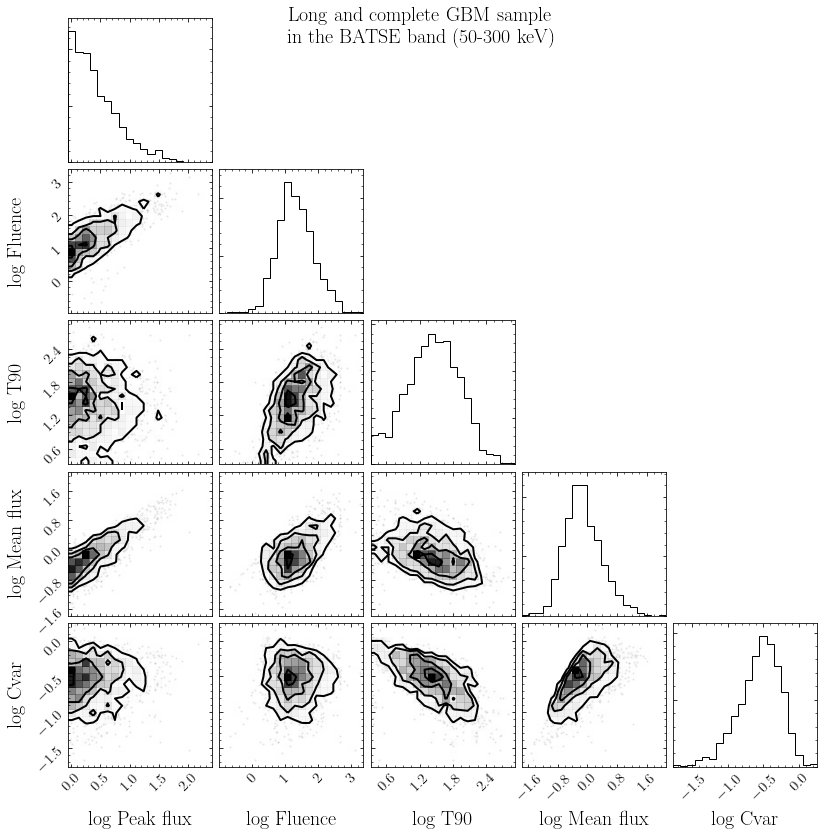

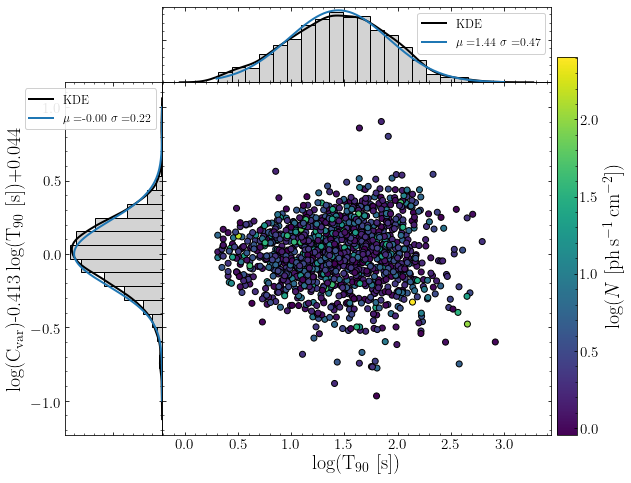

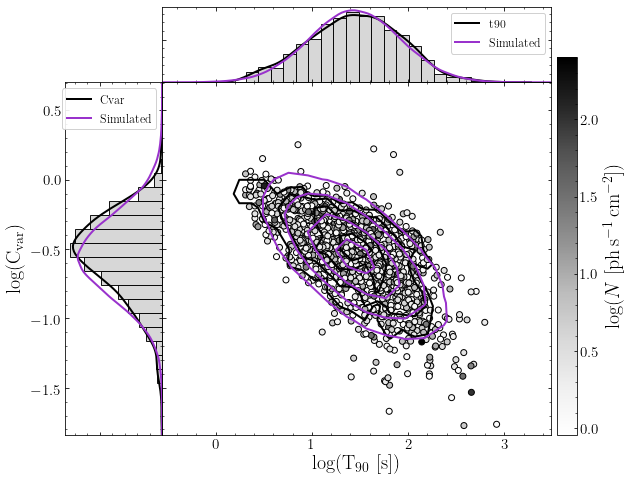

In [6]:
filename = Path('../catalogs/GBM_cat/fermi_GBM_cat_total.dat')
summary_of_Cvar(filename,
                sample_name='GBM in 50-300 keV band',
                pflx_key='pflx_band_phtfluxb',
                flnc_key='flnc_band_phtflncb',
                lac=True, pflx_min=0.9)

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)


Results of Cvar analysis for sample GBM in 50-300 keV band
best_slope : -0.375
best_intercept : -6.767
mu_decorr : -0.000
sigma_decorr : 0.202
mu_t90 : 1.475
sigma_t90 : 0.430


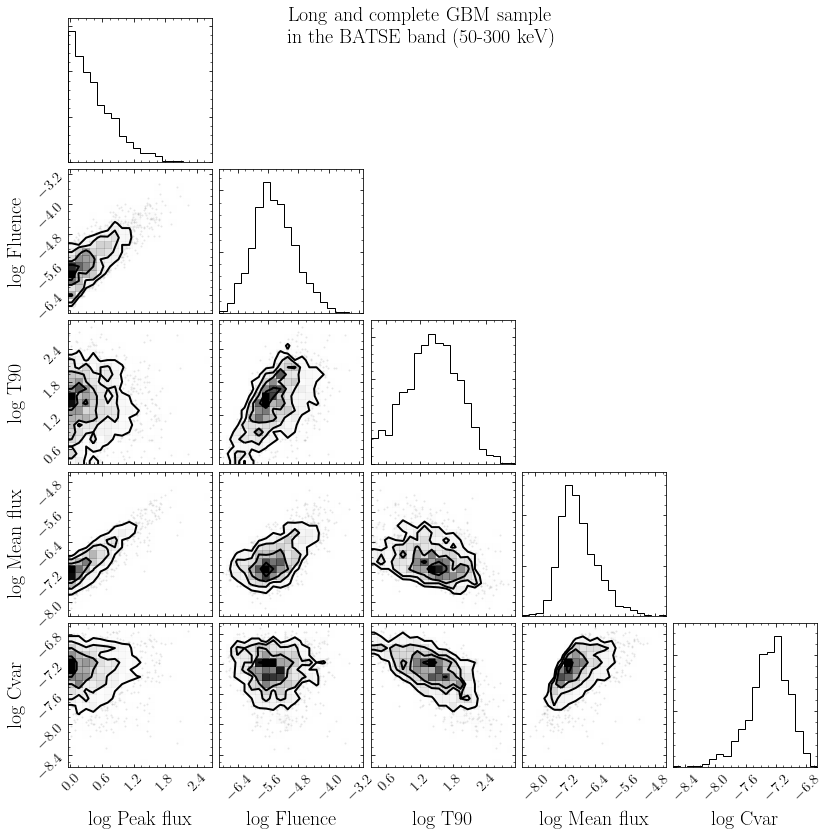

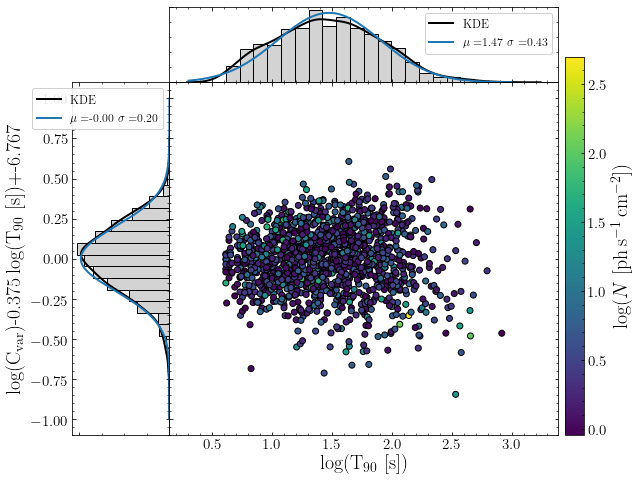

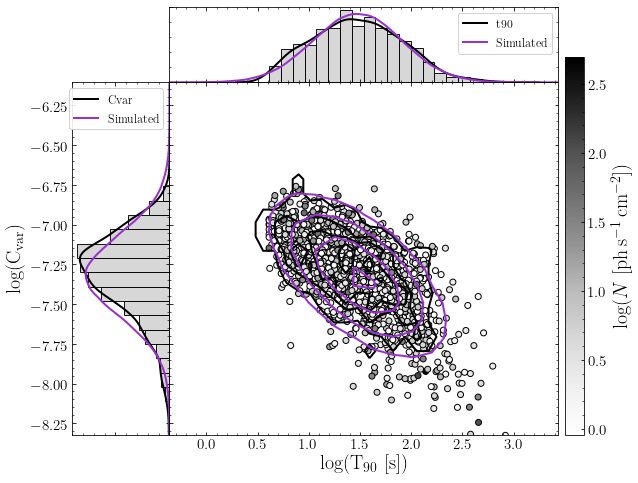

In [7]:
filename = Path('../catalogs/GBM_cat/fermi_GBM_cat_total.dat')
summary_of_Cvar(filename,
                sample_name='GBM in 50-300 keV band',
                pflx_key='flux_batse_1024',
                flnc_key='fluence_batse',
                lac=True, pflx_min=0.9)

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)


Results of Cvar analysis for sample GBM in 10-1000 keV band
best_slope : -0.393
best_intercept : 0.088
mu_decorr : -0.000
sigma_decorr : 0.212
mu_t90 : 1.429
sigma_t90 : 0.469


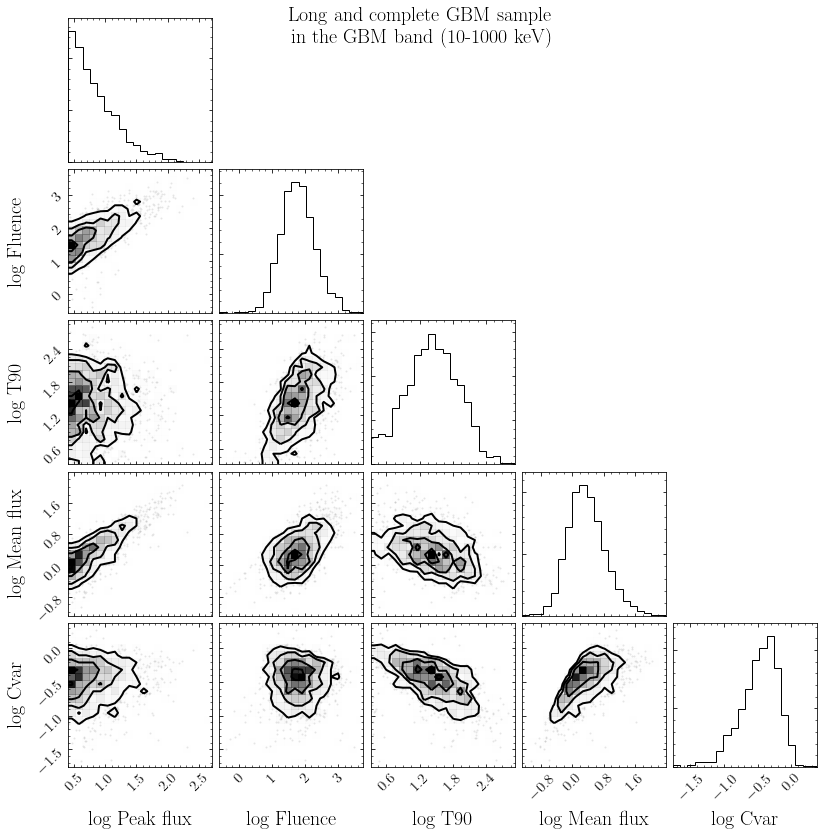

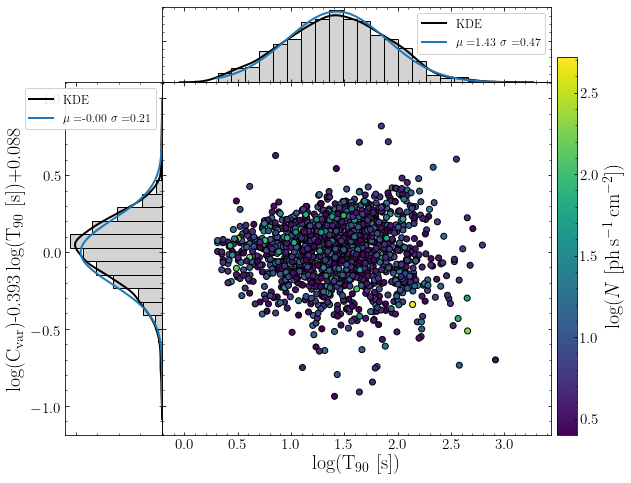

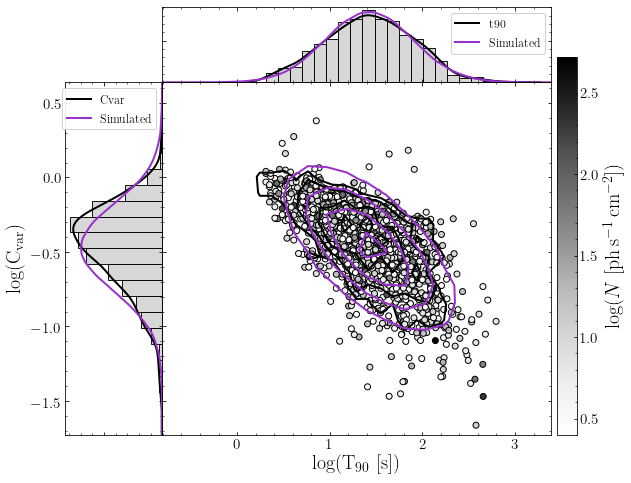

In [9]:
filename = Path('../catalogs/GBM_cat/fermi_GBM_cat_total.dat')
summary_of_Cvar(filename,
                sample_name='GBM in 10-1000 keV band',
                pflx_key='pflx_band_phtflux',
                flnc_key='flnc_band_phtflnc',
                lac=True, pflx_min=2.5,
               fig_title='Long and complete GBM sample\nin the GBM band (10-1000 keV)')

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)


Results of Cvar analysis for sample BATSE in 50-300 keV band
best_slope : -0.389
best_intercept : -6.700
mu_decorr : 0.000
sigma_decorr : 0.269
mu_t90 : 1.537
sigma_t90 : 0.438


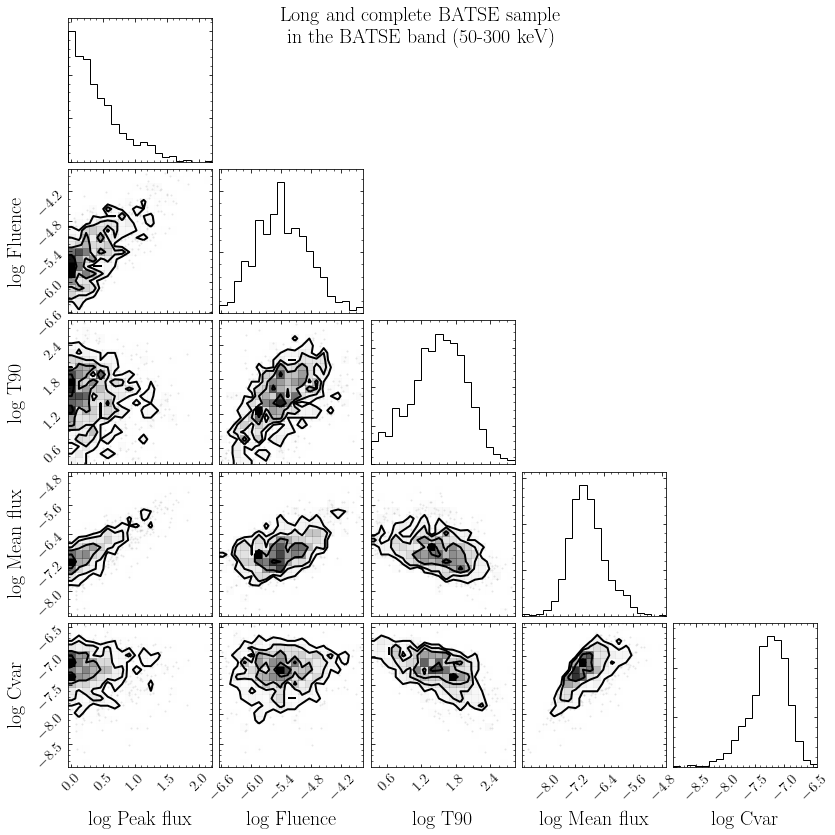

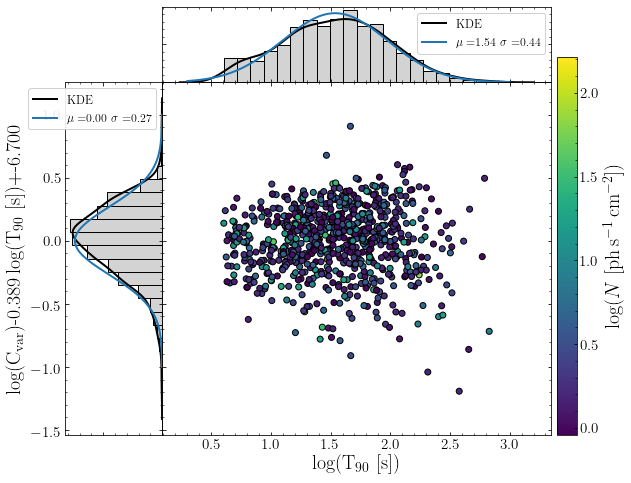

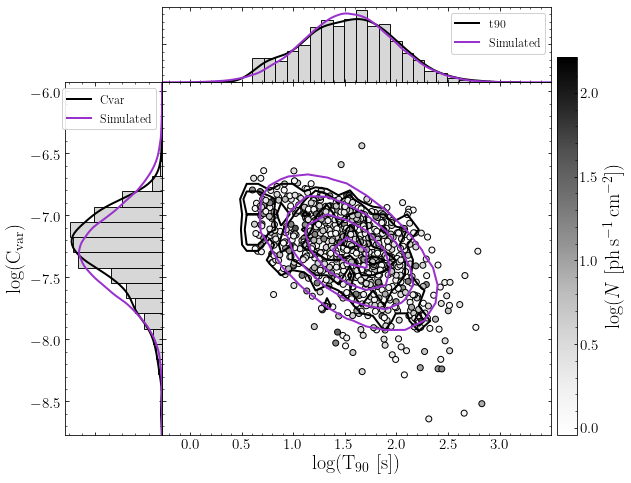

In [10]:
filename = Path('../catalogs/BATSE_cat/BATSE_cat_latest.txt')
summary_of_Cvar(filename,
                sample_name='BATSE in 50-300 keV band',
                pflx_key='flux_1024',
                flnc_key='fluence_2',
                add_fluences=True,
                lac=True, pflx_min=0.9,
                fig_title='Long and complete BATSE sample\nin the BATSE band (50-300 keV)')


In [12]:
from scipy.stats import linregress
import sys
src_dir = '/Users/palmerio/Science_projects/GRB_population_model/grbpop/'
sys.path.insert(0, src_dir)
import miscellaneous as msc
filename = Path('../catalogs/GBM_cat/fermi_GBM_cat_total.dat')

keys = ['pflx_band_epeak', 'flnc_band_epeak', 'pflx_band_phtflux', 't90']

df = msc.create_filtered_sample(filename,
                                keys=keys,
                                func=[msc.filter_df, msc.filter_df],
                                func_args=[{'filtering_key':'t90', 'lim_min':2, 'errors':'coerce'},
                                           {'filtering_key':'pflx_band_phtflux', 'lim_min':0.9, 'errors':'coerce'}],
                                log=False, errors='coerce')



log flnc_Ep = log pflx_Ep * 0.788 + 0.418


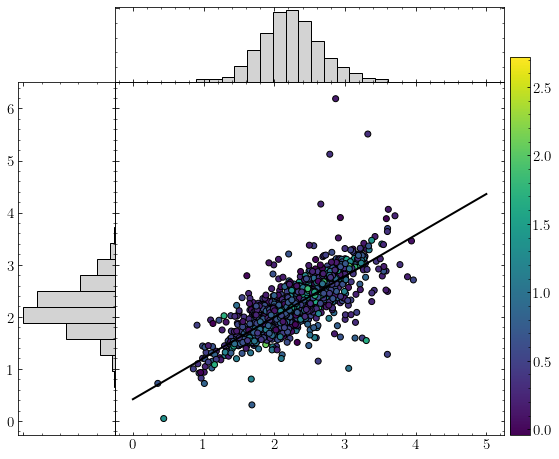

In [17]:
df = df[keys].copy()
df.dropna(inplace=True)



best_slope, best_intercept, r_value, p_value, std_err = linregress(np.log10(df['pflx_band_epeak']),
                                                              np.log10(df['flnc_band_epeak']))

fig, axes = pf.cool_hist2d(np.log10(df['pflx_band_epeak']),
               np.log10(df['flnc_band_epeak']),
               c=np.log10(df['pflx_band_phtflux']),
               plot_left_kdeplot=False, plot_top_kdeplot=False)

x = np.linspace(0, 5)
y = best_slope * x + best_intercept
axes['center'].plot(x,y,c='k')
print('log flnc_Ep = log pflx_Ep * {:.3f} + {:.3f}'.format(best_slope, best_intercept))

plt.show()


mu: 0.044 +0.212 -0.186


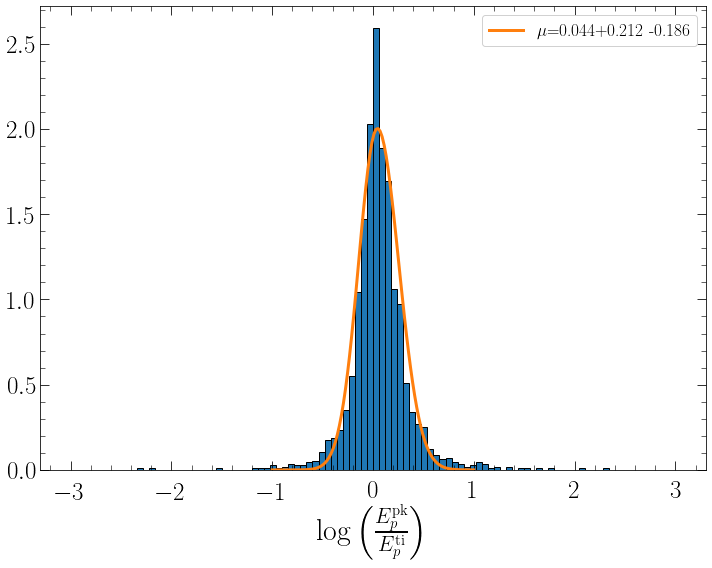

In [30]:
import scipy.stats as stats
df['log ratio Ep'] = np.log10(df['pflx_band_epeak']/ df['flnc_band_epeak'])
q = stats.mstats.mquantiles(df['log ratio Ep'], prob=[0.16, 0.5, 0.84])
mu = q[1]
errp  = q[2]-q[1]
errm  = q[1]-q[0]
print('mu: {:.3f} +{:.3f} -{:.3f}'.format(mu, errp, errm))
plt.style.use('paper')
fig, ax = plt.subplots()
ax.hist(df['log ratio Ep'], bins=np.linspace(-3,3,101), density=True)
x = np.linspace(-1,1, 100)
ax.plot(x, pf.anpdf(x, mu, s1=errm, s2=errp), label=r'$\mu$ = {:.3f} +{:.2f} -{:.2f}'.format(mu, errp, errm))
ax.legend()
ax.set_xlabel(r'$\log\left( \frac{E_p^{\rm pk}}{E_p^{\rm ti}} \right)$')
plt.show()